In [9]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

from momaapi import MOMA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from s3dg import S3D

In [10]:
tsne = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=512, random_state=42)
# kmeans = KMeans(n_clusters=91, random_state=42)

In [11]:
xs = []
for filename in os.listdir("slot"):
    x = np.load(os.path.join("slot", filename)).squeeze()
    xs.append(x)
xs = np.concatenate(xs, axis=0)
xs = pca.fit_transform(xs)
print(xs.shape)

(2712, 512)


In [12]:
moma = MOMA("/data/dir_moma")
sact_list = moma.taxonomy["sact"]
model = S3D("s3d_dict.npy", 512)
model.load_state_dict(torch.load("s3d_howto100m.pth"))
model = model.eval()
# model = model.to("cuda")
with torch.no_grad():
    text_output = model.text_module(sact_list)
cemb = text_output["text_embedding"]

xs = torch.from_numpy(xs)
xs = F.normalize(xs, dim=-1)
cemb = F.normalize(cemb, dim=-1)
sim = torch.mm(xs, cemb.t())
_, topk_idx = torch.topk(sim, dim=1, k=1)


<class 'numpy.ndarray'>
(91, 512)


/opt/conda/envs/faiss/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/faiss/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


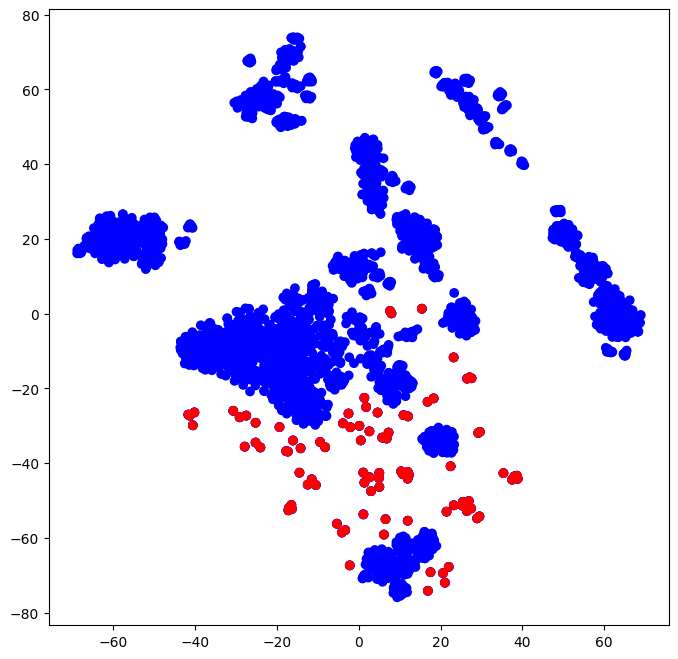

In [16]:
n, m = xs.shape[0], cemb.shape[0]
xs = np.concatenate((xs, cemb), axis=0)
colors = ["blue"] * n + ["red"] * m
xs_2d = tsne.fit_transform(xs)

plt.figure(figsize=(8, 8))
plt.scatter(xs_2d[:,0], xs_2d[:,1], c=colors)
plt.show()